# Introduction

Do not spend too much time trying to get very tiny metrics improvement. Once you have a model with a correct predictive power, you should better spend time explaining your data cleaning & preparation pipeline as well as explanations & visualizations of the results.

The goal is to see your fit with our company culture & engineering needs, spending 50h on an over-complicated approach will not give you bonus points compared to a simple, yet effective, to-the-point solution.

## About the data

The dataset you will be working with is called Emo-DB and can be found [here](http://emodb.bilderbar.info/index-1280.html).

It is a database containing samples of emotional speech in German. It contains samples labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information")
   
The goal of this project is to develop a model which is able to **classify samples of emotional speech**. Feel free to use any available library you would need, but beware of re-using someone else's code without mentionning it!

## Deliverable

The end-goal is to deliver us:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a very brief presentation covering the following points:
    * Introduction to the problem (what are we trying to achieve and why) - max 1 slide
    * Libraries used - max 1 slide
    * Data Processing Pipeline - max 2 slides
    * Feature Engineering (if relevant) - max 1 slide
    * Modeling - max 1 slide
    * Results & Visualization - max 2 slides
* The goal of the presentation is to make it **understandable by a business person**, apart from how modeling techniques which do not have to be explained how they work.

# Libraries Loading

In [1]:
import os
from pandas.plotting import scatter_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import warnings
import random

import seaborn as sns
from scipy import stats

from IPython.display import Audio

%matplotlib inline

from scipy.io import wavfile

from os import listdir
from os.path import isfile, join


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import pylab
import wave

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

from PIL import Image, ImageDraw


from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction

Using TensorFlow backend.
/Users/fessiali/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Data Preparation & Cleaning

Let's have a small look at an example of the audio presented in the dataSet and the feature

In [2]:
data_folder = './data/wav/'
Germanlettertoenglish={'W': 'Anger', 'L': 'Boredom','E': 'Disgust','A': 'Fear','F': 'Hapiness','T': 'Sadness','N': 'Neutral'}
files = [file for file in listdir(data_folder)]
randomIndex=random.randint(0,len(files))
RandomExample=Audio(data_folder+files[randomIndex]) 
print("Sentiment of this random file : "+Germanlettertoenglish[files[randomIndex][5]])
RandomExample

Sentiment of this random file : Hapiness


In [3]:
[Fs, x] = audioBasicIO.readAudioFile(data_folder+files[randomIndex]);
F, f_names = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.050*Fs, 0.025*Fs);

Let's now build the dataFrame. As for now we will not consider other features as age/Sex of the person etc.. At the end of the notebook I have added a small part about data exploratory work where these features will be analyzed. 
Our data frame will contain 34 featurs reprezenting important metrics about our audio file (Energy,MFCCs,etc...). Buidling the dataframe may take ~15 secondes. Enough time to go check your Instagram feed... :)

In [4]:
data = pd.DataFrame(data=np.zeros((len(files),len(f_names))),columns=f_names)
data["Sentiment"]=""
for i in range(len(files)):
    file=files[i]
    [Fs, x] = audioBasicIO.readAudioFile(data_folder+file);
    F, f_names = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.050*Fs, 0.025*Fs);
    for j in range(len(F)):
        #data.iloc[i,j]=(F[j].mean()+F[j].max()+F[j].min()+F[j].std())/4
        data.iloc[i,j]=F[j].std()
        data.iloc[i,len(F)]=file[5]
SentimentEncoder= LabelEncoder()
data['Sentiment']=SentimentEncoder.fit_transform(data['Sentiment'].astype(str))
mappingSentiment = dict(zip(range(len(SentimentEncoder.classes_)),SentimentEncoder.classes_))        

While filling our dataFrame for the input feature that will be used later on we have tryied several mathmetical functions that could be highly correlated to the sentiment expressed by the person. Using the standard deviation of each feature extracted from the samples was the best one.

# Feature Engineering & Modeling

Standardizing method of the features.

In [5]:
def standardize(column):    
    data[column]=data[column]-np.mean(data[column],axis=0)
    data[column]=data[column]/np.std(data[column], axis=0)

In [6]:
for column in data[f_names]:
    standardize(column)

In [7]:
X=data[f_names].values
y=data['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* #### Logistic regression

In [8]:
regr = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
RegressionAccScore=regr.score(X_test,y_test)
print("Acuracy: %.2f%%" % (RegressionAccScore*100))

Acuracy: 70.09%


/Users/fessiali/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


* #### Simple Neural Network

Let's first put our y values into categorical arrays

In [9]:
y_trainNN = np_utils.to_categorical(y_train)
y_testNN = np_utils.to_categorical(y_test)
outputDim=len(y_testNN[0])

In [10]:
model = Sequential()
model.add(Dense(len(files), input_dim=34, kernel_initializer='normal',
activation='relu'))
model.add(Dense(outputDim, kernel_initializer='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history=model.fit(X_train, y_trainNN, validation_data=(X_test, y_testNN), epochs=30, batch_size=10,
verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_testNN, verbose=0)
print("Acuracy: %.2f%%" % (scores[1]*100))

Train on 428 samples, validate on 107 samples
Epoch 1/30
 - 0s - loss: 1.4287 - acc: 0.4883 - val_loss: 1.1837 - val_acc: 0.6262
Epoch 2/30
 - 0s - loss: 0.9788 - acc: 0.6682 - val_loss: 1.0132 - val_acc: 0.6636
Epoch 3/30
 - 0s - loss: 0.8064 - acc: 0.7477 - val_loss: 0.8849 - val_acc: 0.7103
Epoch 4/30
 - 0s - loss: 0.6676 - acc: 0.7967 - val_loss: 0.8208 - val_acc: 0.6822
Epoch 5/30
 - 0s - loss: 0.5766 - acc: 0.8271 - val_loss: 0.7765 - val_acc: 0.7103
Epoch 6/30
 - 0s - loss: 0.5036 - acc: 0.8435 - val_loss: 0.7222 - val_acc: 0.7383
Epoch 7/30
 - 0s - loss: 0.4417 - acc: 0.8832 - val_loss: 0.7245 - val_acc: 0.7290
Epoch 8/30
 - 0s - loss: 0.3846 - acc: 0.8925 - val_loss: 0.6991 - val_acc: 0.7477
Epoch 9/30
 - 0s - loss: 0.3438 - acc: 0.9182 - val_loss: 0.6890 - val_acc: 0.7290
Epoch 10/30
 - 0s - loss: 0.3035 - acc: 0.9369 - val_loss: 0.6723 - val_acc: 0.7757
Epoch 11/30
 - 0s - loss: 0.2651 - acc: 0.9486 - val_loss: 0.6669 - val_acc: 0.7664
Epoch 12/30
 - 0s - loss: 0.2330 - acc:

* #### K-nearest Neighbors

In [11]:
# creating odd list of K for KNN
neighbors = list(range(1,70))

# empty list that will hold cv scores
cv_scores = []

# perform 5-fold cross validation
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# determining best number of neighbors n
optimal_n = neighbors[np.argmax(cv_scores)]
print("The optimal number of neighbors is %d" % optimal_n)

The optimal number of neighbors is 12


In [12]:
#knn = KNeighborsClassifier(n_neighbors=optimal_n)
knn = KNeighborsClassifier(n_neighbors=optimal_n)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

score = accuracy_score(y_test, y_pred_knn)

print("The final score for KNN : " + str(score*100)+"%")

The final score for KNN : 60.747663551401864%


* #### SVM

In [13]:
svclassifier = SVC(kernel='poly', degree=1)  
svclassifier.fit(X_train, y_train)
y_pred_svm = svclassifier.predict(X_test)
scoreSVM=svclassifier.score(X_test,y_test)
print("The final score for SVM : " + str(scoreSVM*100)+"%")


The final score for SVM : 70.09345794392523%


/Users/fessiali/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 ### Feature Selection

Selecting the best k

In [14]:
print("former result without feature selection for logistic regression was "+str(RegressionAccScore))
k_scores = []
for k in range (1,len(f_names)):
    X_new = SelectKBest(f_classif, k=k).fit_transform(X, y)
    X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
    regr = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
    regr.fit(X_new_train, y_new_train)
    y_pred = regr.predict(X_new_test)
    k_scores.append(regr.score(X_new_test,y_new_test))
print(" New result with feature selection for logistic regression "+str(np.amax(k_scores))+" by selecting the msot "+ str(np.argmax(k_scores))+" important features")



former result without feature selection for logistic regression was 0.7009345794392523


/Users/fessiali/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/fessiali/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/fessiali/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/fessiali/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/fessiali/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/linear

 New result with feature selection for logistic regression 0.7102803738317757 by selecting the msot 32 important features


/Users/fessiali/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/fessiali/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/fessiali/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


As we see the improvement we got is not amazing. Not worth applying it to all the other modesl

# Results & Visualizations

Some visulisations are presented here for result 

* #### Simple Neural Network

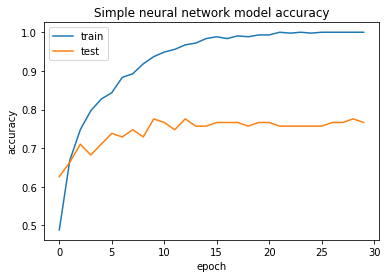

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Simple neural network model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

* #### SVM

In [16]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.53      0.57      0.55        14
           1       0.43      0.50      0.46        12
           2       0.83      0.56      0.67        18
           3       0.88      0.70      0.78        20
           4       0.65      0.69      0.67        16
           5       0.75      1.00      0.86         9
           6       0.81      0.94      0.87        18

   micro avg       0.70      0.70      0.70       107
   macro avg       0.70      0.71      0.69       107
weighted avg       0.72      0.70      0.70       107



We clearly see the bad effects of unbisaed data...

# Other work done 


I have also tried to do the same modeling by representing the signal audios as images and then treat them as that in order to get a good prediction of it. 
I have also constructed another dataFrame cotaining some informations that could be usefull for analytics work. 


In [17]:
PersonIdToGender={'03': 'm', '08': 'f','09': 'f','10': 'm','11': 'm','12': 'f','13': 'f','14': 'f','15': 'm','16': 'f'}
PersonIdToAge={'03': 31, '08': 34,'09': 21,'10': 32,'11': 26,'12': 30,'13': 32,'14': 35,'15': 25,'16': 31}


In [18]:
analytics = pd.DataFrame(np.zeros((len(files), 0)))
analytics["PersonId"]=""
analytics["Age"]=""
analytics["Gender"]=""
analytics["Sentence_id"]=""
analytics["Sentiment"]=""
for i in range(len(files)):
    analytics.iloc[i,0]=files[i][0:2]
    analytics.iloc[i,1]=PersonIdToAge[files[i][0:2]]
    analytics.iloc[i,2]=PersonIdToGender[files[i][0:2]]    
    analytics.iloc[i,3]=files[i][2:5]
    analytics.iloc[i,4]=files[i][5]

In [19]:
analytics

,PersonId,Age,Gender,Sentence_id,Sentiment
0,03,31,m,a01,F
1,03,31,m,a01,N
2,03,31,m,a01,W
3,03,31,m,a02,F
4,03,31,m,a02,N
5,03,31,m,a02,T
6,03,31,m,a02,W
7,03,31,m,a02,W
8,03,31,m,a04,A
9,03,31,m,a04,F


In [20]:
SennteceEnconder = LabelEncoder()
analytics['Sentence_id']=SennteceEnconder.fit_transform(analytics['Sentence_id'].astype(str))
mappingSentence = dict(zip(range(len(SennteceEnconder.classes_)),SennteceEnconder.classes_))
SentimentEncoder= LabelEncoder()
analytics['Sentiment']=SentimentEncoder.fit_transform(analytics['Sentiment'].astype(str))
mappingSentiment = dict(zip(range(len(SentimentEncoder.classes_)),SentimentEncoder.classes_))
GendertEncoder= LabelEncoder()
analytics['Gender']=GendertEncoder.fit_transform(analytics['Gender'].astype(str))
mappingGender = dict(zip( range(len(GendertEncoder.classes_)),GendertEncoder.classes_))

In [21]:
analytics

,PersonId,Age,Gender,Sentence_id,Sentiment
0,03,31,1,0,2
1,03,31,1,0,4
2,03,31,1,0,6
3,03,31,1,1,2
4,03,31,1,1,4
5,03,31,1,1,5
6,03,31,1,1,6
7,03,31,1,1,6
8,03,31,1,2,0
9,03,31,1,2,2


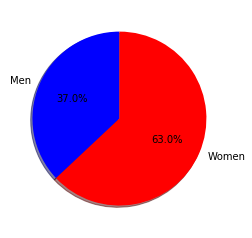

In [22]:
count=analytics.groupby(['Gender']).count()['PersonId']
labels = 'Men', 'Women'
sizes = [count[1],count[0]]
colors = ['blue', 'red']
plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

In [23]:
analytics.groupby(['Age','Sentiment']).count()['PersonId']

Age  Sentiment
21   0             1
     1             8
     2             4
     3             4
     4             9
     5             4
     6            13
25   0             8
     1             5
     2             6
     3             9
     4            11
     5             4
     6            13
26   0            10
     1             2
     2             8
     3             8
     4             9
     5             7
     6            11
30   0             6
     1             2
     2             2
     3             5
     4             4
     5             4
     6            12
31   0            11
     1            12
     2            18
     3            19
     4            16
     5            16
     6            28
32   0            15
     1             9
     2            14
     3            18
     4            13
     5             8
     6            22
34   0             6
     2            11
     3            10
     4            10
     5             

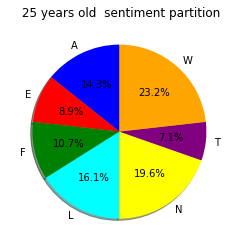

In [24]:
countBySentiment=analytics.groupby(['Age','Sentiment']).count()['PersonId']
labels = list(mappingSentiment.values())
sizes = [countBySentiment[0+7*1],countBySentiment[1+7*1],countBySentiment[2+7*1],countBySentiment[3+7*1],countBySentiment[4+7*1],countBySentiment[5+7*1],countBySentiment[6+7*1]]
colors =['blue', 'red','green','Aqua','yellow','purple','orange']
plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title(" 25 years old  sentiment partition")
plt.show()


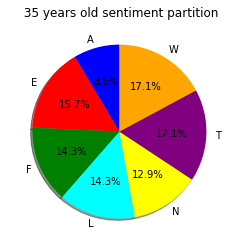

In [25]:
labels = list(mappingSentiment.values())
sizes = [countBySentiment[0+7*6],countBySentiment[1+7*6],countBySentiment[2+7*6],countBySentiment[3+7*6],countBySentiment[4+7*6],countBySentiment[5+7*6],countBySentiment[6+7*6]]
colors =['blue', 'red','green','Aqua','yellow','purple','orange']
plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title(" 35 years old sentiment partition")
plt.show()

A lot of other work could also be done in data exploration